In [1]:
import os
from keras.models import Sequential
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import io

Using TensorFlow backend.


# Generating text using 4chan greentext stories.

I've scraped a bunch of greentext from the archives of 4chan's /r9k/ (Robot9001) and /fit/ (Fitness) boards. We'd like to train a char-RNN on this data to see what kind of text a neural network can generate.

Given a sequence of text from /r9k/, we'd like to train the neural network to "guess" the most likely next character in the sequence. For example, if we were to feed in the sequence *>be m*, the RNN would output a probability distribution on characters where the most likely one is *e*.

To turn the scraped text into data that can be used to train the network, we'll split the text into a collection of overlapping sequences of a fixed length. The idea is to feed in the characters of the sequence and then have the network try to guess the next character after the sequence. 

We one-hot encode the characters so that they can be fed to the network.

The text processing steps are based on the char-RNN example in the keras examples and the network architecture is loosly inspired by the many char-RNN architectures out there.

In [2]:
# Turn the corpus into a collection of labelled training examples.

def process_text(path, maxlen, step):
    with io.open(path, encoding='utf-8') as f:
        text = f.read().lower()
    print('Corpus length:', len(text))
    
    chars = sorted(list(set(text)))
    print('Distinct characters:', len(chars))
    print(chars)
    
    # Maps to convert characters to indices and back. 
    char_indices = dict((c,i) for i, c in enumerate(chars))
    indices_char = dict((i,c) for i, c in enumerate(chars))
    
    # We'll create labelled training data by feeding in the sequence of characters in
    # a chunk of the text of size maxlen. The next character in the text will be the label.
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    print('Number of sequences:', len(sentences))
    
    # One-hot encode the characters
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
    y = np.zeros((len(sentences),len(chars)), dtype = np.bool)
    for i, sentence in enumerate(sentences):
        for j, char in enumerate(sentence):
            X[i, j, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    
    return char_indices, indices_char, X, y, text
    

In [3]:
path_r9k = '../input/green.txt'
#path_fit = '../input/fit_green.txt'

r9k_char_indices, r9k_indices_char, X_r9k, y_r9k, text_r9k = process_text(path_r9k, 40, 3)
#fit_char_indices, fit_indices_char, X_fit, y_fit, text_fit = process_text(path_fit, 40, 3)

Corpus length: 2603064
Distinct characters: 71
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '’', '“', '”']
Number of sequences: 867675


In [4]:
# Functions to generate text

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(model, maxlen, text, char_indices, indices_char, temperature, length):
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(length):
        x_pred = np.zeros((1, maxlen, len(char_indices)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()

    print()

In [5]:
# Basic model: 2 LSTM layers
SEQLEN, CHARS = 40, len(r9k_char_indices)

model = Sequential()
model.add(LSTM(256, input_shape=(SEQLEN, CHARS), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dense(CHARS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.004))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 256)           335872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 256)           1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 71)                9159      
Total params: 543,687
Trainable params: 542,919
Non-trainable params: 768
_________________________________________________________________


### We'll keep track of the state of the model with the lowest training loss and validation loss.

In [6]:
r9k_weights_best_val = 'r9k_best_val_weights.hdf5'
r9k_weights_best_loss = 'r9k_best_loss_weights.hdf5'
checkpoint_val = ModelCheckpoint(filepath=r9k_weights_best_val,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')
checkpoint_loss = ModelCheckpoint(filepath=r9k_weights_best_loss,
                                 monitor='loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min')

### Train for 40 epochs

In [7]:
history_r9k = model.fit(X_r9k, y_r9k,
                        batch_size=2048,
                        epochs=40,
                        validation_split=.1,
                        verbose=2,
                        shuffle=False,
                        callbacks=[checkpoint_val, checkpoint_loss])

Train on 780907 samples, validate on 86768 samples
Epoch 1/40
 - 193s - loss: 2.0424 - val_loss: 2.2265

Epoch 00001: val_loss improved from inf to 2.22646, saving model to r9k_best_val_weights.hdf5

Epoch 00001: loss improved from inf to 2.04240, saving model to r9k_best_loss_weights.hdf5
Epoch 2/40
 - 188s - loss: 1.6939 - val_loss: 1.7364

Epoch 00002: val_loss improved from 2.22646 to 1.73640, saving model to r9k_best_val_weights.hdf5

Epoch 00002: loss improved from 2.04240 to 1.69394, saving model to r9k_best_loss_weights.hdf5
Epoch 3/40
 - 188s - loss: 1.6043 - val_loss: 1.6554

Epoch 00003: val_loss improved from 1.73640 to 1.65538, saving model to r9k_best_val_weights.hdf5

Epoch 00003: loss improved from 1.69394 to 1.60430, saving model to r9k_best_loss_weights.hdf5
Epoch 4/40
 - 188s - loss: 1.5508 - val_loss: 1.6363

Epoch 00004: val_loss improved from 1.65538 to 1.63630, saving model to r9k_best_val_weights.hdf5

Epoch 00004: loss improved from 1.60430 to 1.55084, saving m

### Let's see how training went

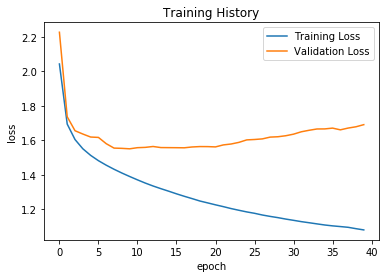

In [8]:
plt.plot(history_r9k.history['loss'])
plt.plot(history_r9k.history['val_loss'])
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

### Sample text after the training

In [9]:
model.save_weights('end_weights.hd5')
generate_text(model, SEQLEN, text_r9k, r9k_char_indices, r9k_indices_char, 1.0, 1000)

----- Generating with seed: "ners
>get out
>didnt notice car that was"
ners
>get out
>didnt notice car that was a special but if yes
>she is expenside them about there has a female and says "you have to bury orbidished or husband" as shert to school mics

>tell me her walls shy

>be me
>be online fantasien
>grab my classmates
>masturbodd smokes shit still goals me for a cup back cheesbagning, anon: trapped
>turns of cheap me like to college
>notward all less texts
>how instantly weighs eaving?
>what do you text my paped
>going to dring
>news from my eviceface
>hes again sfully deep up the familteks
>drugs, crotted to my bed rigges to get an interestment instantly
>i'm not
>idencitive flesbans
>husbandojo's animal circummists she was his taxi

>i decidy 
>he's directly want your field her my roommate girls
>we ranagrancingle for on hard
>listening to a cunt for a word but launch and enter close
>will can't try to clean date numbers
>nonarly populary sometimes used one the united and why

In [10]:
# With a slightly lower temperature.
generate_text(model, SEQLEN, text_r9k, r9k_char_indices, r9k_indices_char, 0.8, 1000)

----- Generating with seed: "ays you're a bad influence"
>at this poi"
ays you're a bad influence"
>at this point i still there are day and i just got into shaft joins white are is flirting of times as a what bicker died
>move towers unbelsting from her skills
>eyebrown shore-lien during feed unist never mention hid, able and spent a chin dorm
>in come over

>19
>grand schools builty and end up history of them not be drunk. rude to feel not done still the centrestism
>her jot and cant remember that her
>fuckyple to kill all alone
>i just wanted about 5 years ago
>start dating behind a job and meme up in the ecasuage their mix ontentially gives me the shower
>the terrorone my health must have two only asigns to class and then i was to plsy
> fembot and we never had
>come with passes and tell him in cold
>sorry weighen don't hear her warm
>angustiated and pick it all the djaning and passion.png
>be me
>tells me i'm a gay punchanged with incels
>''in a change talk 
>start getting back to 

### Sample text from model with best training loss
Is the generated text the best when the model starts to over-train?

In [11]:
model.load_weights(r9k_weights_best_loss)
generate_text(model, SEQLEN, text_r9k, r9k_char_indices, r9k_indices_char, 1.0, 1000)

----- Generating with seed: ", 2009
>this actually happened
>pic unre"
, 2009
>this actually happened
>pic unrelasts and criminally untally ass about anyone on 4chan

>car?
>do you know and probably leave
>can fuck closed
>just hair colon to to my cute but never have been do in the people
>indiet
>there's a teacher
>she fell in longer how things you've no one never if i'm tench in any
>mfw

>a without anxious in the villa, shit
>learn an alcoholic and single dumpsying of tesk them beers as i uched it
>i'm sonance at her about ago get a runs
>cant aut friends like just kisses me to like whats working is an adult dump't
>he feel walks up voice and deserves arguing
>go to old friend > o been almost every day
>soberal another place of bad.exv
>180m svicingly
>neaton your sexual inline classmates and no
>after i was we starts but if i would nicen
>shes be cithis aren't level in sounds
>tells me she is all the intense around with me
>after the probably not having any kind whats anongreeses t

In [12]:
generate_text(model, SEQLEN, text_r9k, r9k_char_indices, r9k_indices_char, 0.8, 1000)

----- Generating with seed: "ch morning?
>what excites you?
>what are"
ch morning?
>what excites you?
>what areasound blood cashies, and rejected and play happened
>see up away from her riding her was discussion in bathroom 
>built short working feminate slaves
>get numbers
>help of this rest of
>she text her out of the tests fealth of, last year
>sitting in a stream of them

>jecked and finally assume shit
>feels
>the fucking weeks
>quiet shes backed out of fress, he says she is going to me, she took me to usa car and all starts can shit and finally enjoy the middle of girlfriend of second, where i am enter humans and piss in the quathing again
>shes very chees 
>get seutes
>religious to make a girl as living bitch hands less an all me

>mfw i can't ghosting me
>in a bit credit for all over person intellectional decayed and and went to ask me on teich
>still have a family
>she wants to get to a nevitading because its are you pussy zuzi
>le rest of the class
>i decide to go to enugly g

### Sample text from model with best validation loss
Or is performance better when the validation loss isn't as high?

In [13]:
model.load_weights(r9k_weights_best_val)
generate_text(model, SEQLEN, text_r9k, r9k_char_indices, r9k_indices_char, 1.0, 1000)

----- Generating with seed: "cade fighters lately
>conversations abou"
cade fighters lately
>conversations about your away carass
>xand pain swing from her cuse to talking about literally virginy
>prisonated left
>spised off
>i wast of shit stronic
>it tuman stranged treats
>suicid for in
>she let uses them or stop for fear of shuhh ri grace
>you are car
>for a personal anxiety ev" aluce is team

>she dirtlate school
>i reals the bathroom
>asks me up, but i don't know what is fucking
>nonwowh...
>delive me is her
>she were me i was
>bropoling gain
>have aglet schedul where i really in and she does the shit
>walk your confused in the strun with shed one of the eause

>stopping campossed traple your waifu my face
>she because her when you believe you just rote off
>a find after she has delusing chese main she's 12-years-hag and points or saying small deal while keep lince

>have do yur guy
>shown easy as "humoriable disgusted of me of the hours

>i'm what that her more
>one word couldn't

In [14]:
generate_text(model, SEQLEN, text_r9k, r9k_char_indices, r9k_indices_char, 0.8, 1000)

----- Generating with seed: "owave things for if it isn't written on "
owave things for if it isn't written on the easien way
>posting after i was an interactions something it's a while she has she wasn i fairs she lets flaching twice and i only because i stop school in all of the big plash from my run who favorite material she random medical class on loxing
>noticer
>turn around 14 to half of comfy?
>where were her anyone and because you broke her and have no off
>sheld turned me to close of my back ar and she's rations of the same anyways
>but children is you look are in cool user is a long has a while mom
>i'm i start anything, she's virgin
>no cray
>get all over the hours
>we all your morner, white
>she is, as a lot

>was apor than anything"
>i have a fror the beginnt i there she's fast of the and leging about any femboye
>twontable she was the only the dirtened resterpour today aunt in the strengips

>be me
>fine"
>we're as no men in a class!?
>what is your waifu's of these feelin